# Overview

I pulled this dataset from [https://www.kaggle.com/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer](https://www.kaggle.com/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer). It is a copy of the raw data from the paper [*A combination of urinary biomarker panel and PancRISK score for earlier detection of pancreatic cancer: A case–control study*](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489) by Debernardi et al.

This notebook analyses the dataset and runs some scikit-learn classifier models with the intent of both semi-reliably detecting pancreatic ductal adenocarcinoma from basic demographic information, blood plasma levels of the antigen CA 19-9, and the urinary concentrations of the biomarkers: creatinine, [LYVE1](https://www.uniprot.org/uniprot/Q9Y5Y7), [TFF1](https://www.uniprot.org/uniprot/P04155), [REG1A](https://www.uniprot.org/uniprot/P05451), and [REG1B](https://www.uniprot.org/uniprot/P48304).

Of these biomarkers, Debernardi et al. have described a panel of LYVE1, TFF1, and REG1B as a useful panel in the detection of pancreatic ductal adenocarcinoma. They have also explored the use of REG1A as a substitute for REG1B.

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Markdown

# Scikit-learn
from sklearn.metrics import accuracy_score, auc, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Load Dataset and Configure

In [2]:
path = './data/Debernardi et al 2020 data.csv'

df_orig = pd.read_csv(path)

# Show the head of the unmodified dataset
display(df_orig)

# Initialize the working dataset df
df = df_orig.copy()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
586,S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
587,S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN
588,S583,Cohort2,BPTB,75,F,3,IV,NaN,NaN,1.33458,8.206777,205.930000,722.523000,NaN


# Explore

## Check Datatypes

In [3]:
display(df.dtypes)

sample_id                   object
patient_cohort              object
sample_origin               object
age                          int64
sex                         object
diagnosis                    int64
stage                       object
benign_sample_diagnosis     object
plasma_CA19_9              float64
creatinine                 float64
LYVE1                      float64
REG1B                      float64
TFF1                       float64
REG1A                      float64
dtype: object

## Initial Statistics

In [4]:
display(df.describe())

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


#### What's up with those zeros?

Nothing here seems amiss. Plasma CA 19-9 numbers vary widely within the dataset with a fair precentage being below 10  

In [5]:
# Show our rows with zeros in it and some distinguishing info.
df_temp1 = df.loc[df['plasma_CA19_9'] == 0]
df_temp2 = df.loc[df['REG1A'] == 0]
df_temp = pd.concat([df_temp1, df_temp2])

selected_cols = ['sample_id', 'diagnosis', 'patient_cohort', 'stage', 'benign_sample_diagnosis', 'plasma_CA19_9', 'REG1A']

display(Markdown('#### Zeros'))
display(df_temp[selected_cols])
display(Markdown(f'Number of rows with zeros: {df_temp.shape[0]}'))

#### Zeros

,sample_id,diagnosis,patient_cohort,stage,benign_sample_diagnosis,plasma_CA19_9,REG1A
77,S169,1,Cohort2,NaN,NaN,0.00,NaN
102,S26,1,Cohort1,NaN,NaN,6.94,0.0
108,S31,1,Cohort1,NaN,NaN,7.86,0.0
111,S34,1,Cohort1,NaN,NaN,6.58,0.0
156,S75,1,Cohort1,NaN,NaN,84.30,0.0
301,S252,2,Cohort1,NaN,Pancreatitis (Alcohol-Chronic),46.10,0.0
306,S281,2,Cohort1,NaN,Pancreatitis (Alcohol-Chronic),30.00,0.0
553,S533,3,Cohort1,III,NaN,422.00,0.0


Number of rows with zeros: 8

#### Check our diagnosis counts

Pretty even split.

In [6]:
diag_map = {1: 'control', 2: 'benign', 3: 'cancer'}

df_temp = df['diagnosis'].map(diag_map)

display(df_temp.value_counts())

benign     208
cancer     199
control    183
Name: diagnosis, dtype: int64

## Check out the NaNs

* The REG1A and Plasma CA 19-9 NaNs mostly result from different collection methods between cohorts. We will impute these to the average for their dianosis.
* Stage NaNs are from healthy controls. We will call the healthy controls stage 0.
* Benign sample diagnosis NaNs are from malignant samples. We will be ignoring this column entirely for this paper.

In [7]:
display(Markdown('#### Count of NaNs by column: '))
display(df.isna().sum())

#### Count of NaNs by column: 

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

## Find outliers

It seems cancer patients tend to have outliers in the biomarkers. After some exploration I'm going to choose to leave these alone, as the standouts all come from different patients, cohorts, and/or origins.

#### First let's make some functions for displaying the data

In [8]:
# Show scatterplots
def show_plots(column: str, df: pd.DataFrame, ylabel: str = None):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(df['sample_id'], df[column], c=df['diagnosis'])
    
    plt.title(column)
    plt.xlabel('Sample ID')
    if ylabel:
        plt.ylabel(ylabel)
    
    plt.show()
    
# Show the top 5 values per data column
def show_top_five(column:str, df: pd.DataFrame):
    df = df[['sample_id', 'patient_cohort', 'sample_origin', 'age', 'sex', 'diagnosis', 'stage', column]]
    df = df.sort_values(by=column, ascending=False)
    display(Markdown(f'#### Table head for {column} datapoints:'))
    display(df.head())

### Check for CA 19-9 outliers

I think we can ignore the obvious outliers in the cancer group.

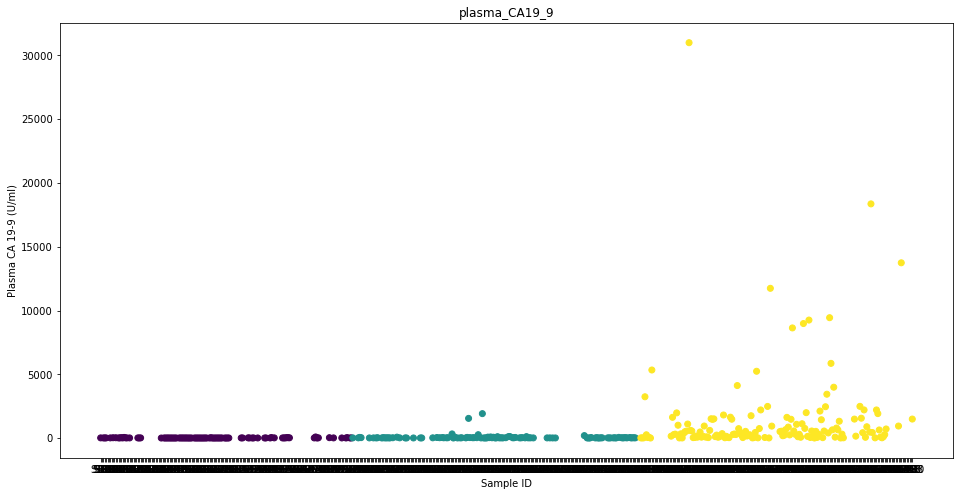

#### Table head for plasma_CA19_9 datapoints:

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,plasma_CA19_9
427,S399,Cohort1,LIV,69,M,3,IIB,31000.0
559,S563,Cohort1,BPTB,53,M,3,III,18360.0
581,S529,Cohort1,BPTB,61,F,3,IV,13740.0
486,S567,Cohort1,BPTB,66,M,3,IIB,11740.0
529,S479,Cohort1,BPTB,60,M,3,III,9436.0


In [9]:
# Show scatterplot
show_plots('plasma_CA19_9', df, ylabel='Plasma CA 19-9 (U/ml)')

# Show top 5
show_top_five('plasma_CA19_9', df)

### Check for outliers in creatinine

Nothing actionable here.

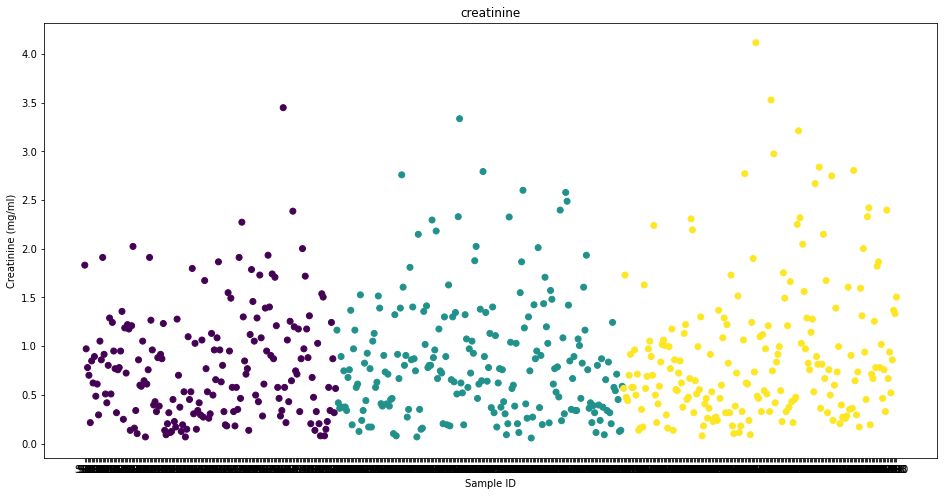

#### Table head for creatinine datapoints:

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,creatinine
487,S572,Cohort2,BPTB,66,F,3,IIB,4.11684
498,S400,Cohort1,LIV,76,M,3,III,3.52872
144,S64,Cohort1,BPTB,48,F,1,NaN,3.44955
272,S205,Cohort1,LIV,31,M,2,NaN,3.33645
518,S460,Cohort1,LIV,56,M,3,III,3.21204


In [10]:
# Show scatterplot
show_plots('creatinine', df, ylabel='Creatinine (mg/ml)')

# Show top 5
show_top_five('creatinine', df)

### Check for outliers in LYVE1

One is way up there. We might be normalizing this later.

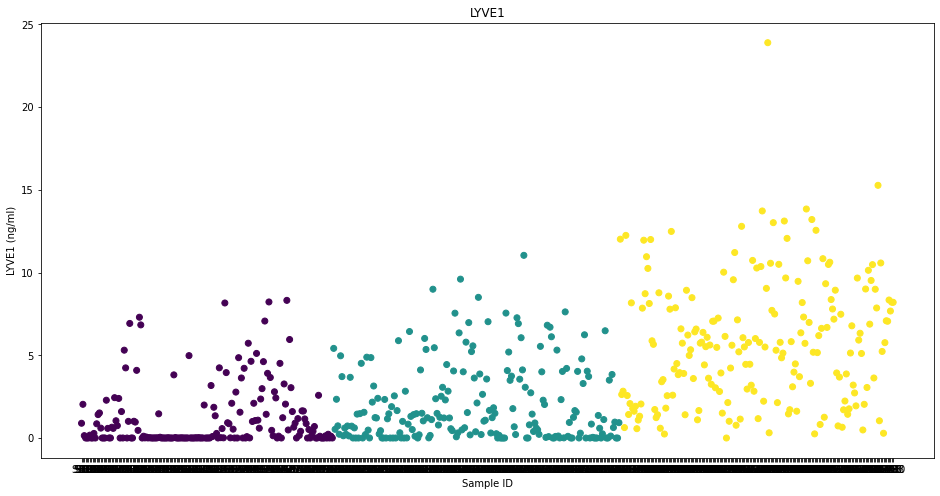

#### Table head for LYVE1 datapoints:

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,LYVE1
498,S400,Cohort1,LIV,76,M,3,III,23.890323
578,S514,Cohort1,ESP,78,M,3,IV,15.270520
526,S474,Cohort1,LIV,75,F,3,III,13.840416
494,S393,Cohort1,LIV,66,F,3,III,13.721790
530,S480,Cohort1,BPTB,66,M,3,III,13.204670


In [11]:
# Show scatterplot
show_plots('LYVE1', df, ylabel='LYVE1 (ng/ml)')

# Show top 5
show_top_five('LYVE1', df)

### Check for outliers in REG1B

We will leave this one alone.

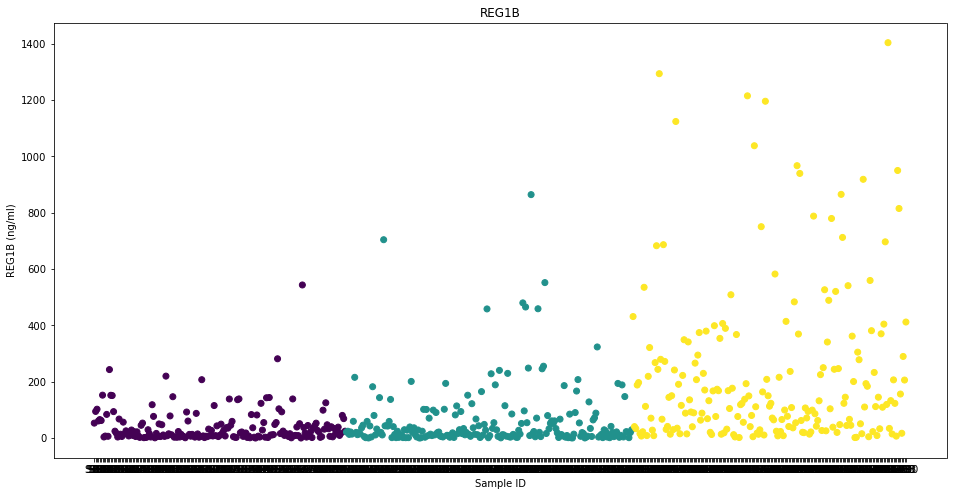

#### Table head for REG1B datapoints:

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,REG1B
576,S509,Cohort1,ESP,65,M,3,IV,1403.89760
410,S504,Cohort1,ESP,54,M,3,II,1293.81945
474,S544,Cohort2,BPTB,79,F,3,IIB,1215.16800
487,S572,Cohort2,BPTB,66,F,3,IIB,1195.97200
422,S527,Cohort2,BPTB,48,M,3,IIA,1124.10800


In [12]:
# Show scatterplot
show_plots('REG1B', df, ylabel='REG1B (ng/ml)')

# Show top 5
show_top_five('REG1B', df)

### Check for outliers in TFF1

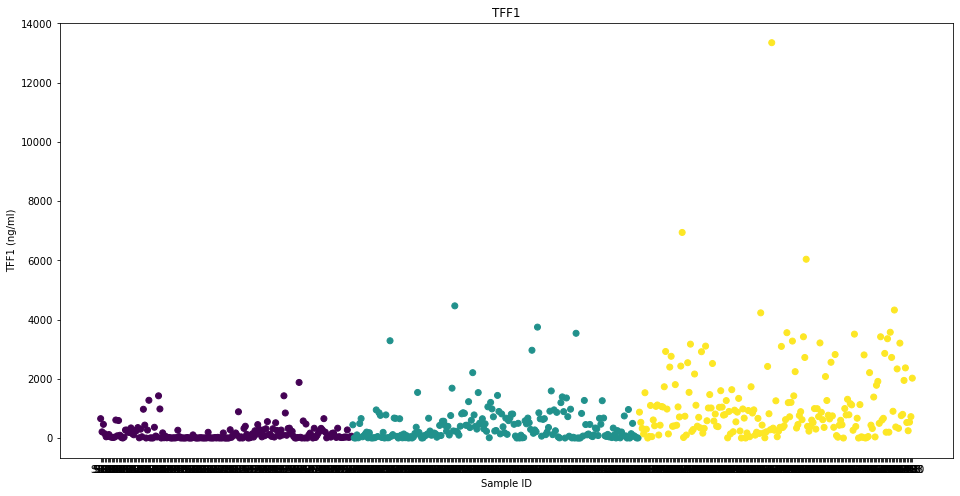

#### Table head for TFF1 datapoints:

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,TFF1
487,S572,Cohort2,BPTB,66,F,3,IIB,13344.300
422,S527,Cohort2,BPTB,48,M,3,IIA,6939.098
512,S439,Cohort1,LIV,67,F,3,III,6035.157
257,S190,Cohort1,LIV,67,M,2,NaN,4461.684
576,S509,Cohort1,ESP,65,M,3,IV,4320.489


In [13]:
# Show scatterplot
show_plots('TFF1', df, ylabel='TFF1 (ng/ml)')

# Show top 5
show_top_five('TFF1', df)

### Check for REG1A antibody outliers

Imputation really does a number here.

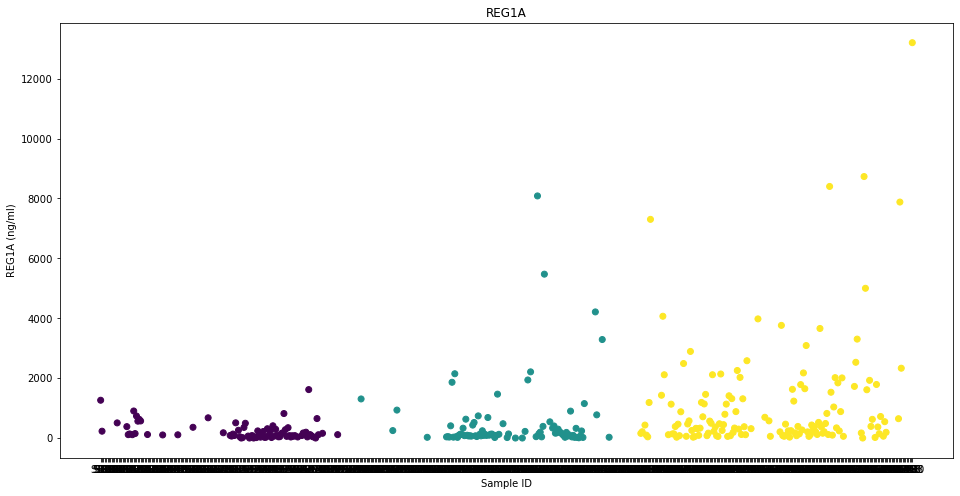

#### Table head for REG1A datapoints:

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,REG1A
589,S590,Cohort1,BPTB,74,M,3,IV,13200.000
554,S536,Cohort1,BPTB,60,M,3,III,8731.000
529,S479,Cohort1,BPTB,60,M,3,III,8400.000
317,S224,Cohort1,ESP,54,F,2,NaN,8083.492
580,S522,Cohort1,BPTB,46,M,3,IV,7879.000


In [14]:
# Show scatterplot
show_plots('REG1A', df, ylabel='REG1A (ng/ml)')

# Show top 5
show_top_five('REG1A', df)

# Prepare and Clean Dataset

## Drop unnecessary columns

In [15]:
df_clean = df_orig.copy()

# Drop the 'benign_sample_diagnosis' (let's just figure out if it is cancer or not)
df_clean = df_clean.drop(labels='benign_sample_diagnosis', axis=1)

# Drop 'patient_cohort'
df_clean = df_clean.drop(labels='patient_cohort', axis=1)

# Drop 'sample_id'
df_clean = df_clean.drop(labels='sample_id', axis=1)

# Drop 'sample_origin'
df_clean = df_clean.drop(labels='sample_origin', axis=1)

df_clean.head()

,age,sex,diagnosis,stage,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,F,1,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,81,F,1,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,51,M,1,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,61,M,1,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,62,M,1,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


## Transform categories to numerical labels

In [16]:
# Replace NaNs in 'stage' with 0 (no cancer)
df_clean[['stage']] = df_clean[['stage']].fillna(value='0')

# Transform 'stage' into into numerical labels
stage_encoder = LabelEncoder()
stage_encoder.fit(df_clean['stage'].unique())
df_clean['stage'] = stage_encoder.transform(df_clean['stage'])

# Tranform 'sex' into numerical labels
sex_encoder = LabelEncoder()
sex_encoder.fit(df_clean['sex'].unique())
df_clean['sex'] = sex_encoder.transform(df_clean['sex'])

## Impute NaNs

Impute to the mean of each diagnosis category.

In [17]:
_mean = lambda x: x.fillna(x.mean())

df_clean['plasma_CA19_9'] = df_clean[['diagnosis','plasma_CA19_9']].groupby('diagnosis').transform(_mean)
df_clean['REG1A'] = df_clean[['diagnosis', 'REG1A']].groupby('diagnosis').transform(_mean)

# Check
display(Markdown(f'#### NaNs after mean imputation: '))
display(df_clean.isna().sum())

#### NaNs after mean imputation: 

age              0
sex              0
diagnosis        0
stage            0
plasma_CA19_9    0
creatinine       0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
dtype: int64

## Statistics after Imputation

We only changed 'plasma_CA19_9' and 'REG1A.' The mean and std moved down for both as expected. 

In [18]:
display(df.describe())

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


# Let's see what scikit can do from here

## Reassign the working DataFrame handle and initialize models

In [25]:
# Reassign working DataFrame handle
df = df_clean.copy()

# Decision Tree
dtc = DecisionTreeClassifier(average='weighted')

# SVM
svc = SVC()

# MLP
mlp = MLPClassifier()

models = [dtc, svc, mlp]

TypeError: __init__() got an unexpected keyword argument 'average'

## Split Data

In [23]:
X = df.loc[:, (df.columns != 'diagnosis') & (df.columns != 'stage')]
Y_cancer = df.loc[:, df.columns == 'diagnosis']
Y_stage = df.loc[:, df.columns == 'stage']


def run_models(models, x, y, test_size=0.5):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_size)

    scores = {}
    
    # Run train and test
    for model in models:
        print(f"Running {model}") # SVC w/ probability is slow
        model = model.fit(x_train, y_train)
        
        #y_probs = model.predict_proba(x_test)[:, 1]
        y_pred = model.predict(x_test)
        
        #precision, recall, _ = precision_recall_curve(y_test, y_probs, pos_label=1)
        #auprc = auc(recall, precision)
        
        f1 = f1_score(y_test, y_pred) # per office hours
        
        accuracy = accuracy_score(y_test, y_pred)
        
        scores[model] = accuracy, f1
        
    return scores

In [24]:
run_models(models, X, Y_cancer)

Running DecisionTreeClassifier()


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].